bell_state:
 [[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]] 

Hamiltonian:
   (1) [Z0 Z1] 



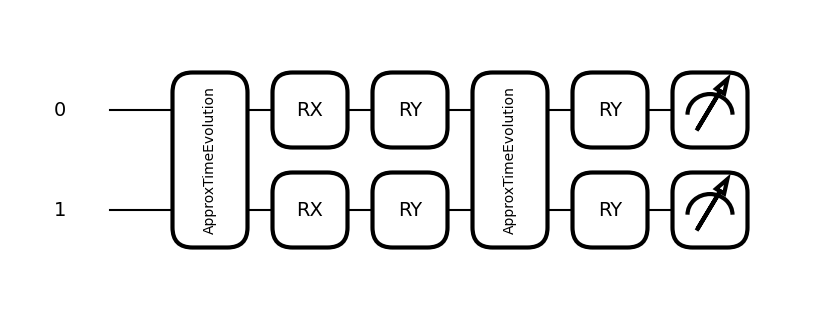

In [1]:
import matplotlib.pyplot as plt
import pennylane as qml
import scipy as sp

from pennylane import numpy as np
from IPython.display import display, Math

#  == impoprt qiskit ==

from qiskit import QuantumCircuit
from qiskit.quantum_info import DensityMatrix
from qiskit.visualization import plot_state_city



np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions()

dev = qml.device('default.qubit', wires= 2)

# == Pre_defined state ==
pauli_x = np.array([ [0, 1], [1, 0]])
pauli_y = np.array([ [0, -1.j], [1.j, 0]])
pauli_z = np.array([ [1, 0], [0, -1]])

# state = (00 + 01 + 10 + 11)/2 = kron(|0> + |1>)/sqrt(2) , (|0> + |1>)/sqrt(2) )
state_super_pos = np.kron( (np.array([[1], [0]]) + np.array([[0], [1]]))/np.sqrt(2) , (np.array([[1], [0]]) + np.array([[0], [1]]))/np.sqrt(2) )
rho_super_pos = np.kron(state_super_pos, state_super_pos.conj().T) 
# state_super_pos, state_super_pos.con().T has different dimension 


# bell state = (|00> + |11>) / 2
state_bell = ( np.kron( np.array([ [1], [0] ]) , np.array([ [1], [0] ]) ) +  np.kron( np.array([ [0], [1] ]) , np.array([ [0], [1] ]) ) )/np.sqrt(2) 
# rho_bell = state_bell @ state_bell.conj().T
rho_bell = np.kron(state_bell , state_bell.conj().T)

print('bell_state:\n',rho_bell,'\n')


# == Hamiltonian setup ==
coeffs = [1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]
# print('Data type:', type(obs))

hamiltonian = qml.Hamiltonian(coeffs, obs)

print('Hamiltonian:\n', hamiltonian,'\n')

# Quantum circuit
@qml.qnode(dev)
def circuit(theta_init, tau_1, tau_2):

    # 1st try = use only tau_1
    
    qml.ApproxTimeEvolution(hamiltonian, tau_1, 1)
    
    qml.RX(theta_init, wires=0)
    qml.RX(theta_init, wires=1)
    
    qml.RY(-np.pi/2, wires=0)
    qml.RY(-np.pi/2, wires=1)
    
    qml.ApproxTimeEvolution(hamiltonian, tau_2, 1)
    
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    
    return qml.density_matrix(wires=[0, 1]) 


# print('circuit_density matrix: \n', circuit(0,0,0))

fig, ax = qml.draw_mpl(circuit)(0, 1, 1)

In [2]:
# == Calculate concurrence ==
def concurrence_calculation(paras):
    
	theta_init, tau_1, tau_2 = paras
 
	rho = circuit(theta_init, tau_1, tau_2).numpy()
	# density matrix casting to numpy
	
	rho_uni = np.kron(pauli_y, pauli_y) @ rho.conj() @ np.kron(pauli_y, pauli_y)
	
	R = sp.linalg.sqrtm( sp.linalg.sqrtm(rho) @ rho_uni @ sp.linalg.sqrtm(rho) )
	# print('Concurrence matrix(R): \n', R)

	# sort array in descending order
	eig_vals = np.sort(sp.linalg.eigvals(R).real)[::-1]
	# print('Eig_val descending order:', eig_vals)

	concurrence = np.amax([ 0, (2*eig_vals[0] - np.sum(eig_vals)) ])	
	# concurrence = 0 vs (2*eig_vals[0] - np.sum(eig_vals)) which is bigger?
	# print('np.amax:', -concurrence)


	# 1-concurrence = minimum => concurrence = max!!
	return 1-concurrence



# == Bell state concurrence ==
def concurrence_bell():
	rho = rho_bell
	rho_uni = np.kron(pauli_y, pauli_y) @ rho.conj() @ np.kron(pauli_y, pauli_y)
 
	R = sp.linalg.sqrtm( sp.linalg.sqrtm(rho) @ rho_uni @ sp.linalg.sqrtm(rho) )

	# sort array in descending order
	eig_vals = np.sort(sp.linalg.eigvals(R).real)[::-1]

	concurrence = np.amax([ 0, (2*eig_vals[0] - np.sum(eig_vals)) ])	
	# concurrence = 0 vs (2*eig_vals[0] - np.sum(eig_vals)) which is bigger?

	# 1-concurrence = minimum => concurrence = max!!
	print('bell-state concurrence: ', concurrence, '\n')
	
	return 0


para = 1,1,1
print('concurrnece before optimize:\n', -1*(concurrence_calculation(para)-1),'\n')

concurrence_bell()

concurrnece before optimize:
 0.9092974138103855 

bell-state concurrence:  0.9999999999999998 



0

density matrix before optimization:
 [[ 0.2105591 +0.00000000e+00j -0.19128685+2.61183063e-02j -0.19128685+2.61183063e-02j -0.17701835+2.45647748e-01j]
 [-0.19128685-2.61183063e-02j  0.17701835+0.00000000e+00j  0.17701835-2.77555756e-17j  0.19128685-2.01206050e-01j]
 [-0.19128685-2.61183063e-02j  0.17701835+2.77555756e-17j  0.17701835+0.00000000e+00j  0.19128685-2.01206050e-01j]
 [-0.17701835-2.45647748e-01j  0.19128685+2.01206050e-01j  0.19128685+2.01206050e-01j  0.43540419+0.00000000e+00j]] 



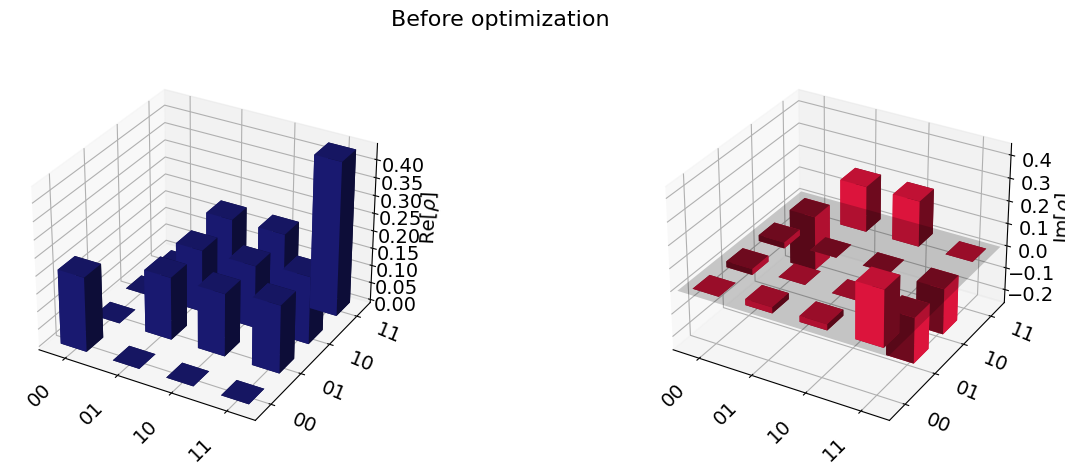

In [3]:
# == before optimize == 
density_matrix_in = circuit(1,1,1)

print('density matrix before optimization:\n',density_matrix_in,'\n')
plot_state_city(density_matrix_in, color=['midnightblue', 'crimson'], title="Before optimization")

In [4]:
# == optimize begin ==

# theta / tau_1 / tau_2
Init_parameters = np.pi, np.pi/2, np.pi/4
result = sp.optimize.minimize(concurrence_calculation, Init_parameters, method='SLSQP')

print('\n\nconcurrence_after_optimize(max): ', -1 * (concurrence_calculation(result.x)-1) )

result



concurrence_after_optimize(max):  0.9999999999999991


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 8.881784197001252e-16
       x: [ 3.142e+00  1.571e+00  7.854e-01]
     nit: 1
     jac: [ 5.902e-05 -4.470e-08  1.490e-08]
    nfev: 4
    njev: 1

density matrix after optimization:
 [[ 5.00000000e-01+0.00000000e+00j -7.85046229e-17-2.77555756e-17j -1.11022302e-16-3.92523115e-17j  2.77555756e-17-5.00000000e-01j]
 [-7.85046229e-17+2.77555756e-17j  1.38666956e-32+0.00000000e+00j  1.96104690e-32+1.36845553e-48j  2.77555756e-17+7.85046229e-17j]
 [-1.11022302e-16+3.92523115e-17j  1.96104690e-32-1.36845553e-48j  2.77333912e-32+0.00000000e+00j  3.92523115e-17+1.11022302e-16j]
 [ 2.77555756e-17+5.00000000e-01j  2.77555756e-17-7.85046229e-17j  3.92523115e-17-1.11022302e-16j  5.00000000e-01+0.00000000e+00j]] 



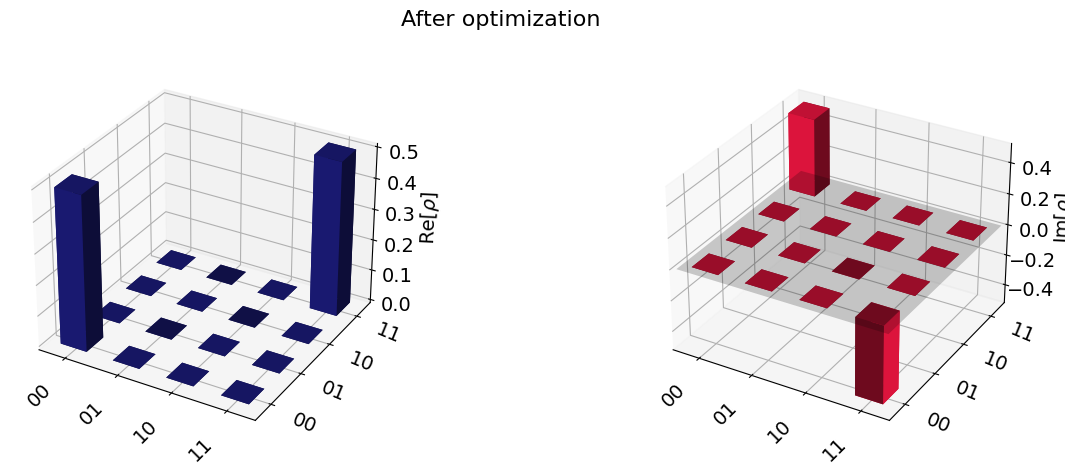

In [5]:
# == After optimize == 
density_matrix_in = circuit(result.x[0],result.x[1],result.x[2])

print('density matrix after optimization:\n',density_matrix_in,'\n')
plot_state_city(density_matrix_in, color=['midnightblue', 'crimson'], title="After optimization")